<a href="https://www.kaggle.com/halilsaglamlar/dogs-cats-classification-with-keras?scriptVersionId=90295840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [33]:
# import libraries

In [34]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [35]:
np.set_printoptions(suppress=True)

# Dataset Info

The Dogs vs. Cats dataset is a common computer vision dataset in which pictures are classified as either including a dog or a cat.

After the dataset is well studied, it can be used to understand and practice how to design, evaluate, and apply convolutional neural networks for image classification.

Here we will build a classifier with images and try to detect dogs versus cats using CNN.

Train set includes 12500 cat-5026 dog images, validation set includes 1219 cat-1071 dog images and test set incgludes 6897 cat and dogs images together. 

In [36]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tensorflow.config import list_physical_devices
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

Num GPUs Available:  1


In [38]:
# read data and check how many class in train set
my_data_dir = '../input/dog-cat/data'

os.listdir(my_data_dir)


['validation', 'test', 'train']

In [39]:
train_path = my_data_dir+'/train'
validation_path = my_data_dir+'/validation'
test_path = my_data_dir+'/test'

os.listdir(train_path)

['dog', 'cat']

**Let's check how many images there are.**

In [40]:
#number of cat images in train set
len(os.listdir(train_path+'/cat'))

12500

In [41]:
#number of dog images in train set
len(os.listdir(train_path+'/dog'))

5026

In [42]:
#take cat image at index 0 from train set
cat_sample = imread(train_path+'/cat/' + os.listdir(train_path+'/cat')[0] )
#take dog image at index 1 from train set
dog_sample = imread(train_path+'/dog/' +  os.listdir(train_path+'/dog')[111] )

#compare their shapes
print("cat shape:", cat_sample.shape,"\ndog shape:", dog_sample.shape)


cat shape: (352, 349, 3) 
dog shape: (499, 300, 3)


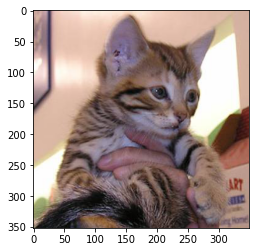

In [43]:
#show cat image
plt.imshow(cat_sample);

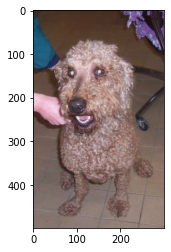

In [44]:
#show dog image
plt.imshow(dog_sample);

**Let's decide on the final dimension of these images.**

In [45]:
cat_sample.shape

(352, 349, 3)

In [46]:
dog_sample.shape

(499, 300, 3)

In [47]:
# dwe will choose 128*128 image size
image_shape = (128,128,3)

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

In [48]:
#use ImageDataGenerator to manipulate the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# help(ImageDataGenerator)

In [49]:
train_datagen = ImageDataGenerator(rescale=1./255,        
                                   width_shift_range=0.1,
                                   height_shift_range=0.1, 
                                   horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)


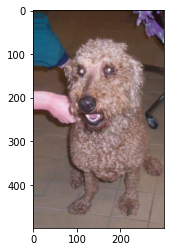

In [50]:
#show transfromed version of dog image
plt.imshow(train_datagen.random_transform(dog_sample));

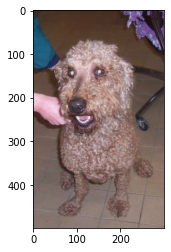

In [51]:
#original iamge
plt.imshow(dog_sample);

### Generating many manipulated images from a directory


flow_from_directory function works with images organized in sub-directories. Your directories should include only one class of images, so one folder per class of images.

main_directory/

.class_a/

......a_image_1.jpg

......a_image_2.jpg

.class_b/

......b_image_1.jpg

......b_image_2.jpg


# Creating the Model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [53]:
#create your CNN model here
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)      

# Early Stopping

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

In [56]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [58]:
batch_size = 64

In [59]:
train_image_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=image_shape[:2],
        batch_size=batch_size,
        class_mode='binary') #

Found 17526 images belonging to 2 classes.


In [60]:
val_image_gen =  test_datagen.flow_from_directory(
        validation_path,
        target_size=image_shape[:2],
        batch_size=batch_size,
        class_mode='binary')

Found 2290 images belonging to 2 classes.


In [61]:
#show class indices in train set
train_image_gen.class_indices

{'cat': 0, 'dog': 1}

In [62]:
val_image_gen.class_indices

{'cat': 0, 'dog': 1}

# Model Training

In [63]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
#fit your model using train and validation set
results = model.fit(train_image_gen,epochs=50,validation_data=val_image_gen, callbacks=[early_stop])

Epoch 1/50
274/274 [==============================] - 138s 500ms/step - loss: 0.5921 - accuracy: 0.7181 - val_loss: 0.6807 - val_accuracy: 0.6218
Epoch 2/50
274/274 [==============================] - 137s 499ms/step - loss: 0.5256 - accuracy: 0.7556 - val_loss: 0.5463 - val_accuracy: 0.7118
Epoch 3/50
274/274 [==============================] - 138s 505ms/step - loss: 0.4785 - accuracy: 0.7842 - val_loss: 0.5211 - val_accuracy: 0.7376
Epoch 4/50
274/274 [==============================] - 137s 501ms/step - loss: 0.4529 - accuracy: 0.7940 - val_loss: 0.6051 - val_accuracy: 0.7135
Epoch 5/50
274/274 [==============================] - 137s 501ms/step - loss: 0.4403 - accuracy: 0.7995 - val_loss: 0.4859 - val_accuracy: 0.7672
Epoch 6/50
274/274 [==============================] - 137s 499ms/step - loss: 0.4128 - accuracy: 0.8170 - val_loss: 0.4985 - val_accuracy: 0.7664
Epoch 7/50
274/274 [==============================] - 139s 506ms/step - loss: 0.4078 - accuracy: 0.8214 - val_loss: 0.5271 -

# Evaluating the Model

In [65]:
losses = pd.DataFrame(results.history)

In [66]:
losses

,loss,accuracy,val_loss,val_accuracy
0,0.592083,0.718076,0.680728,0.621834
1,0.525562,0.755563,0.546275,0.711790
2,0.478497,0.784206,0.521138,0.737555
3,0.452905,0.793963,0.605122,0.713537
4,0.440340,0.799498,0.485855,0.767249
5,0.412849,0.816958,0.498487,0.766376
6,0.407788,0.821351,0.527092,0.752402
7,0.383506,0.832649,0.459027,0.785590
8,0.372792,0.836129,0.414246,0.815284
9,0.364939,0.841321,0.458527,0.796943


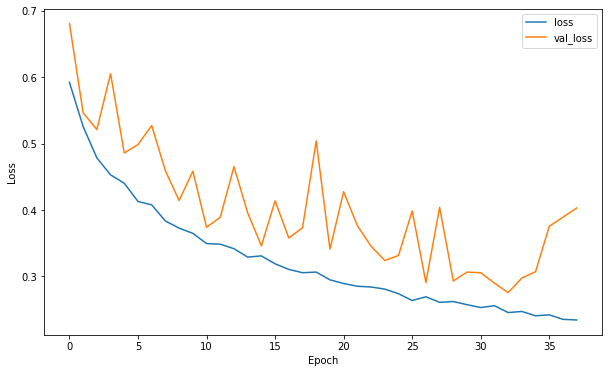

In [67]:
plt.figure(figsize=(10,6))
plt.plot(losses.loss, label="loss")
plt.plot(losses.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show();

In [68]:
model.metrics_names

['loss', 'accuracy']

In [69]:
val_image_gen =  test_datagen.flow_from_directory(
        validation_path,
        target_size=image_shape[:2],
        batch_size=batch_size,shuffle=False,
        class_mode='binary')

Found 2290 images belonging to 2 classes.


In [88]:
model.evaluate(val_image_gen)

36/36 [==============================] - 7s 201ms/step - loss: 0.4031 - accuracy: 0.8450


[0.4030626714229584, 0.8449781537055969]

In [89]:
val_pred_probabilities = model.predict(val_image_gen)

In [90]:
val_predictions = val_pred_probabilities > 0.5

In [91]:
from sklearn.metrics import classification_report,confusion_matrix


print(classification_report(val_image_gen.classes,val_predictions))
confusion_matrix(val_image_gen.classes,val_predictions)


              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1219
           1       0.96      0.70      0.81      1071

    accuracy                           0.84      2290
   macro avg       0.87      0.84      0.84      2290
weighted avg       0.87      0.84      0.84      2290



array([[1188,   31],
       [ 324,  747]])

In [92]:
test_image_gen =  test_datagen.flow_from_directory(my_data_dir,
                                                    target_size=image_shape[:2],
                                                    batch_size=5,
                                                    class_mode=None,  
                                                    shuffle=False,
                                                    classes=['test'],
)

Found 6897 images belonging to 1 classes.


In [93]:
test_pred_probabilities = model.predict(test_image_gen)

In [94]:
view_size=10

In [95]:
test_predictions = test_pred_probabilities > 0.5
test_predictions[:view_size]

array([[ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False]])

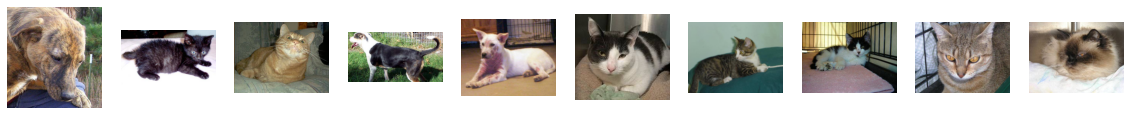

In [96]:
test_samples = test_image_gen.filenames[:view_size]

fig, axes = plt.subplots(1,view_size, figsize=(20, 10))

for i,ax in zip(test_samples,axes.flatten()):
    img=imread(my_data_dir +"/"+ i)
    ax.imshow(img)
    ax.axis('off')

In [97]:
from tensorflow.keras.models import load_model
model.save('cat_dog_detector.h5')

# Predicting on an Image

In [98]:
from PIL import Image

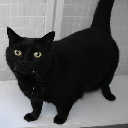

In [99]:
#read 2749.jpg from test set
my_image = image.load_img(test_path +"/"+"2749.jpg",target_size=image_shape)
my_image

In [100]:
# resize it as 128 * 128

In [101]:
# turn the image into numpy array
my_image = image.img_to_array(my_image)
my_image.shape

(128, 128, 3)

In [102]:
#reshape it as below
my_image = my_image.reshape((1, 128, 128, 3))
my_image.shape

(1, 128, 128, 3)

In [103]:
#predict the image class with your model
model.predict(my_image)

array([[0.]], dtype=float32)

In [104]:
train_image_gen.class_indices

{'cat': 0, 'dog': 1}

In [105]:
val_image_gen.class_indices

{'cat': 0, 'dog': 1}

Credits: This project is a part of [Clarusway](https://clarusway.com/) Data Science Course. And some codes are adapted from course metarials.